In [161]:
import pandas as pd

In [162]:
%matplotlib inline
df = pd.read_csv('2017_2018.csv')
df = df[['DATUM', 'HEMMA','BORTA','HS', 'VS', 'DEC', 'PERIOD']]
df['DATUM'] = pd.to_datetime(df['DATUM'], format = '%Y-%m-%d')

teams = df['HEMMA'].\
    drop_duplicates().\
    to_frame().\
    reset_index().\
    drop('index',1).\
    reset_index().\
    set_index('HEMMA')['index']
teams = teams + 1
teams

HEMMA
Skellefteå     1
Malmö          2
Växjö          3
Örebro         4
Rögle          5
Färjestad      6
Frölunda       7
Mora           8
Djurgården     9
Luleå         10
Brynäs        11
Linköping     12
HV71          13
Karlskrona    14
Name: index, dtype: int64

In [163]:
df_hemma = df[['DATUM', 'HEMMA', 'HS']].copy()
df_hemma.columns = ['date', 'team', 'goals']
df_hemma['home'] = 1
df_borta = df[['DATUM', 'BORTA', 'VS']].copy()
df_borta.columns = ['date', 'team', 'goals']
df_borta['home'] = 0

df = df_hemma.append(df_borta)
df.head(5)
df['team_no'] = df['team'].map(teams)
df = df.groupby(['team', 'home']).mean()
df

goals  team_no
team       home                   
Brynäs     0     2.000000     11.0
           1     1.857143     11.0
Djurgården 0     2.428571      9.0
           1     3.142857      9.0
Frölunda   0     2.833333      7.0
           1     2.625000      7.0
Färjestad  0     3.500000      6.0
           1     3.571429      6.0
HV71       0     2.250000     13.0
           1     2.571429     13.0
Karlskrona 0     1.166667     14.0
           1     1.625000     14.0
Linköping  0     2.250000     12.0
           1     2.857143     12.0
Luleå      0     1.857143     10.0
           1     2.250000     10.0
Malmö      0     2.500000      2.0
           1     3.142857      2.0
Mora       0     1.555556      8.0
           1     3.600000      8.0
Rögle      0     2.000000      5.0
           1     3.000000      5.0
Skellefteå 0     3.666667      1.0
           1     3.375000      1.0
Växjö      0     2.166667      3.0
           1     3.625000      3.0
Örebro     0     2.750000      4.0
           1     2.166667      4.0

In [159]:
df = df.groupby('team').mean()
df

KeyError: 'team'

In [137]:
stan_code = '''
data{
    int<lower=1> N;
    int<lower=1> N_team;
    int goals[N];
    int team[N];
    real home[N];
}
parameters{
    vector[N_team] alpha;
    real beta;
    real mu_a;
    real mu_b;
    real<lower=0> sigma_a;
    real<lower=0> sigma_b;
}
model{
    vector[N] lambda;
    sigma_b ~ cauchy( 0 , 1 );
    sigma_a ~ cauchy( 0 , 1 );
    mu_b ~ normal( 0 , 1 );
    mu_a ~ normal( 1 , 1 );
    beta ~ normal( mu_b , sigma_b );
    alpha ~ normal( mu_a , sigma_a );
    for ( i in 1:N ) {
        lambda[i] = alpha[team[i]] + beta * home[i];
    }
    goals ~ poisson_log( lambda );
}
generated quantities{
    vector[N] lambda;
    real dev;
    dev = 0;
    for ( i in 1:N ) {
        lambda[i] = alpha[team[i]] + beta * home[i];
    }
    dev = dev + (-2)*poisson_log_lpmf( goals | lambda );
}
'''

In [138]:
df['team_no'].drop_duplicates().shape[0]

14

In [139]:
d_dat = {}
d_dat['N'] = df.shape[0]
d_dat['N_team'] = df['team_no'].drop_duplicates().shape[0]
d_dat['goals'] = df['goals'].tolist()
d_dat['team'] = df['team_no'].tolist()
d_dat['home'] = df['home'].tolist()


In [140]:
import pystan
sm = pystan.StanModel(model_code=stan_code)
fit = sm.sampling(data=d_dat, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0b7d47eb7256ea939cd47120b6e2287d NOW.


In [153]:
fit.extract()['alpha'][0]

array([ 0.91778048,  0.92109137,  0.80476689,  0.80100819,  0.77562159,
        1.09125585,  0.96676526,  0.83975366,  0.81901067,  0.7314441 ,
        0.7346798 ,  0.7823809 ,  0.84701135,  0.87365454])

In [150]:
print (fit)

Inference for Stan model: anon_model_0b7d47eb7256ea939cd47120b6e2287d.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[0]      0.99  4.5e-3   0.13   0.74    0.9   0.98   1.08   1.26    866    1.0
alpha[1]      0.88  3.8e-3   0.13   0.63    0.8   0.88   0.96   1.14   1143    1.0
alpha[2]      0.91  4.3e-3   0.13   0.64   0.82    0.9   0.99   1.17    955    1.0
alpha[3]      0.83  3.8e-3   0.13   0.59   0.75   0.83   0.92   1.08   1062   1.01
alpha[4]      0.82  3.1e-3   0.14   0.53   0.73   0.83   0.91   1.07   2000   1.01
alpha[5]      1.01  4.9e-3   0.13   0.75   0.93   1.01    1.1   1.28    721    1.0
alpha[6]      0.85  3.9e-3   0.13   0.59   0.77   0.86   0.94   1.11   1097    1.0
alpha[7]      0.79  4.1e-3   0.13   0.52   0.71    0.8   0.89   1.04   1047    1.0
alpha[8]      0.88  3.9e-3   0.13   0.63   0.79   0.88   0.96   1.

In [47]:
df['VS'].mean()

2.2637362637362637

In [48]:
df['VS'].var()

2.4040807677171316

In [83]:
dfl = df[df['HEMMA'] == 'Färjestad']
dfl['HS'].mean()

2.8076923076923075

In [84]:
dfl = df[df['BORTA'] == 'Färjestad']
dfl['VS'].mean()

2.3076923076923075

In [55]:
dfl['HS'].var()

2.3446153846153845

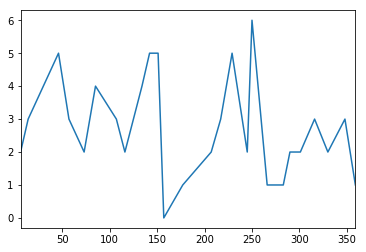

In [59]:
dfl.set_index('DATUM')
dfl['HS'].plot()

In [65]:
df['HEMMA'].drop_duplicates()

0           HV71
1          Växjö
2     Karlskrona
3          Luleå
4     Skellefteå
5        Leksand
6      Linköping
9         Brynäs
10         Rögle
13         Malmö
15        Örebro
16    Djurgården
18     Färjestad
20      Frölunda
Name: HEMMA, dtype: object

In [64]:
dfl.shape

(26, 7)